In [1]:
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from sleeprnn.data import utils
from sleeprnn.common import viz, constants
from sleeprnn.helpers import reader

viz.notebook_full_width()

In [2]:
dataset = reader.load_dataset(constants.PINK_NAME, load_checkpoint=True, verbose=False)

# Check one "subject"

In [3]:
subject_id = 2

subject_data = dataset.read_subject_data(subject_id)
for key in subject_data.keys():
    print(key, subject_data[key].shape, subject_data[key].dtype)
signal, marks = dataset.get_subject_data(subject_id, normalize_clip=False)

signal (2168000,) float32
n2_pages (540,) int16
all_pages (540,) int16
hypnogram (542,) <U1
marks_1 (0, 2) int32


In [4]:
def draw_signal(n2_page_loc):
    fig, ax = plt.subplots(1, 1, figsize=(12, 2), dpi=180)
    n2_page_id = n2_page_loc + 1
    start_sample = int(n2_page_id * dataset.page_size)
    end_sample = int(start_sample + dataset.page_size)
    page_signal = signal[n2_page_loc]
    time_axis = np.arange(start_sample, end_sample) / dataset.fs
    ax.plot(time_axis, page_signal, linewidth=0.7, color=viz.PALETTE['blue'])
    ax.set_title(" N2 page %d (page in record: %d) (Subject %s)" % (n2_page_loc, n2_page_id, subject_id))
    ax.set_ylim([-150, 150])
    ax.set_xlim([time_axis[0], time_axis[-1]])
    plt.show()

In [5]:
init_page_loc = 0

style = {'description_width': 'initial'}
layout= widgets.Layout(width='1000px')
widgets.interact(
    lambda n2_page_loc: draw_signal(n2_page_loc),
    n2_page_loc=widgets.IntSlider(
        min=0, max=signal.shape[0]-1, step=1, value=init_page_loc, 
        continuous_update=False,
        style=style,
        layout=layout
    ));

interactive(children=(IntSlider(value=0, continuous_update=False, description='n2_page_loc', layout=Layout(wid…

# Check spectrum of one "subject"

In [6]:
def get_mean_spectrum(signal_pages, fs=200, min_freq=1, max_freq=29):
    tmp = []
    for i in range(signal_pages.shape[0]):
        power, freq = utils.power_spectrum(signal_pages[i], fs, apply_hanning=True)
        tmp.append(power)
    mean_power_own = np.stack(tmp, axis=1).mean(axis=1)
    valid_locs = np.where((freq >= min_freq) & (freq <= max_freq))[0]
    freq = freq[valid_locs]
    mean_power_own = mean_power_own[valid_locs]
    return freq, mean_power_own

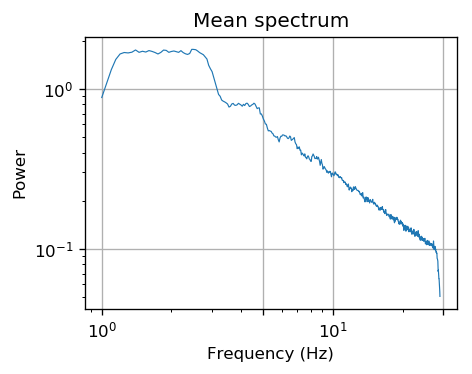

In [7]:
freq, mean_power_own = get_mean_spectrum(signal)

fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=120)
ax.set_title("Mean spectrum")
ax.loglog(freq, mean_power_own, linewidth=0.7)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power")
ax.set_xticks([1, 5, 10, 30])
ax.grid()
plt.show()

# Compare with mass

In [8]:
mass = reader.load_dataset(constants.MASS_SS_NAME, load_checkpoint=True, verbose=False)

In [9]:
subject_id_mass = 1
mass_signal, mass_marks = mass.get_subject_data(subject_id, which_expert=1, normalize_clip=False)

In [10]:
mass_signal.shape

(911, 4000)

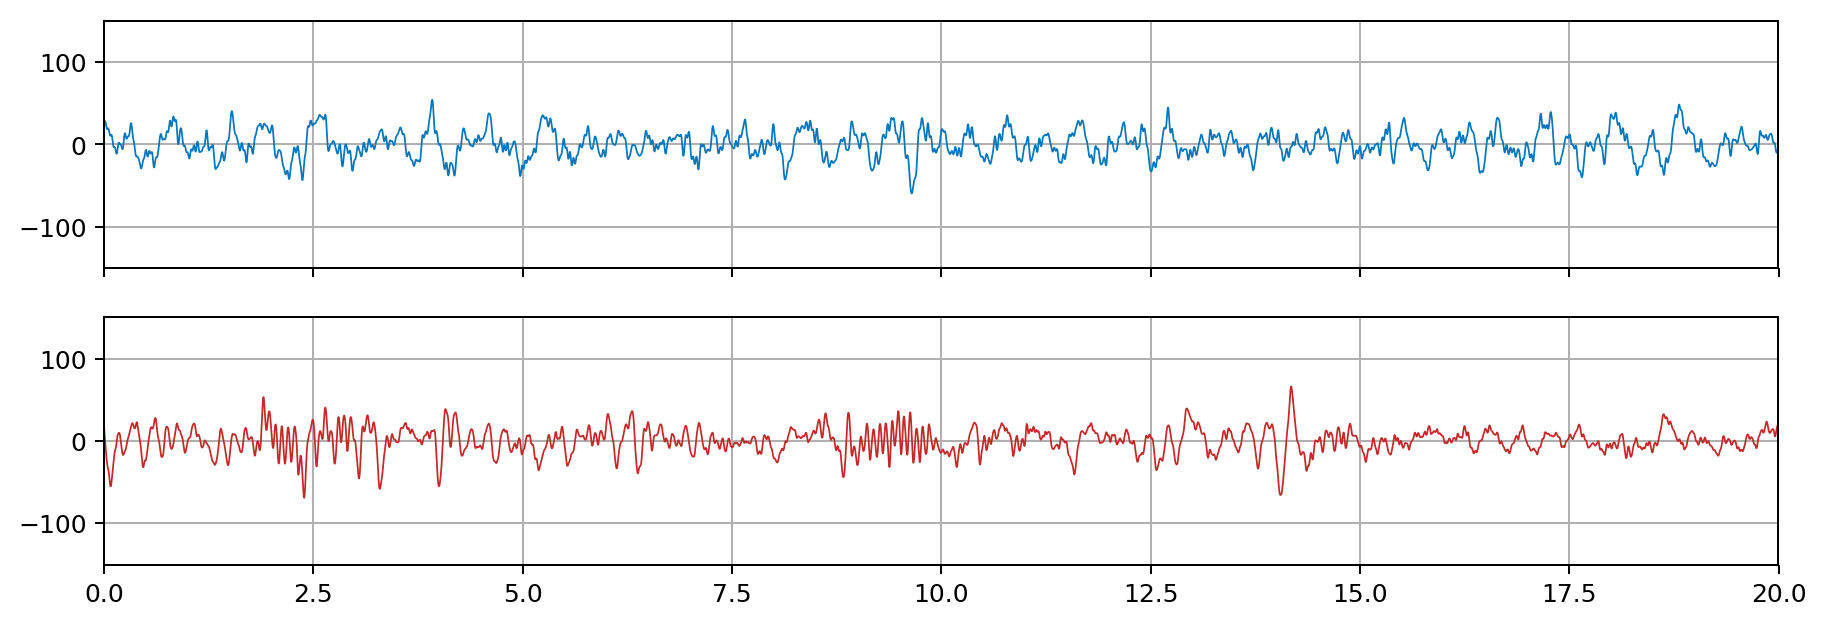

In [11]:
which_pink = 10
which_mass = 10
fig, ax = plt.subplots(2, 1, figsize=(12, 4), dpi=180, sharex=True)
time_axis = np.arange(dataset.page_size) / dataset.fs
ax[0].plot(time_axis, signal[which_pink, :], linewidth=0.7, color=viz.PALETTE['blue'])
ax[1].plot(time_axis, mass_signal[which_mass, :], linewidth=0.7, color=viz.PALETTE['red'])
for s_ax in ax.flatten():
    s_ax.set_ylim([-150, 150])
    s_ax.set_xlim([time_axis[0], time_axis[-1]])
    s_ax.grid()
plt.show()

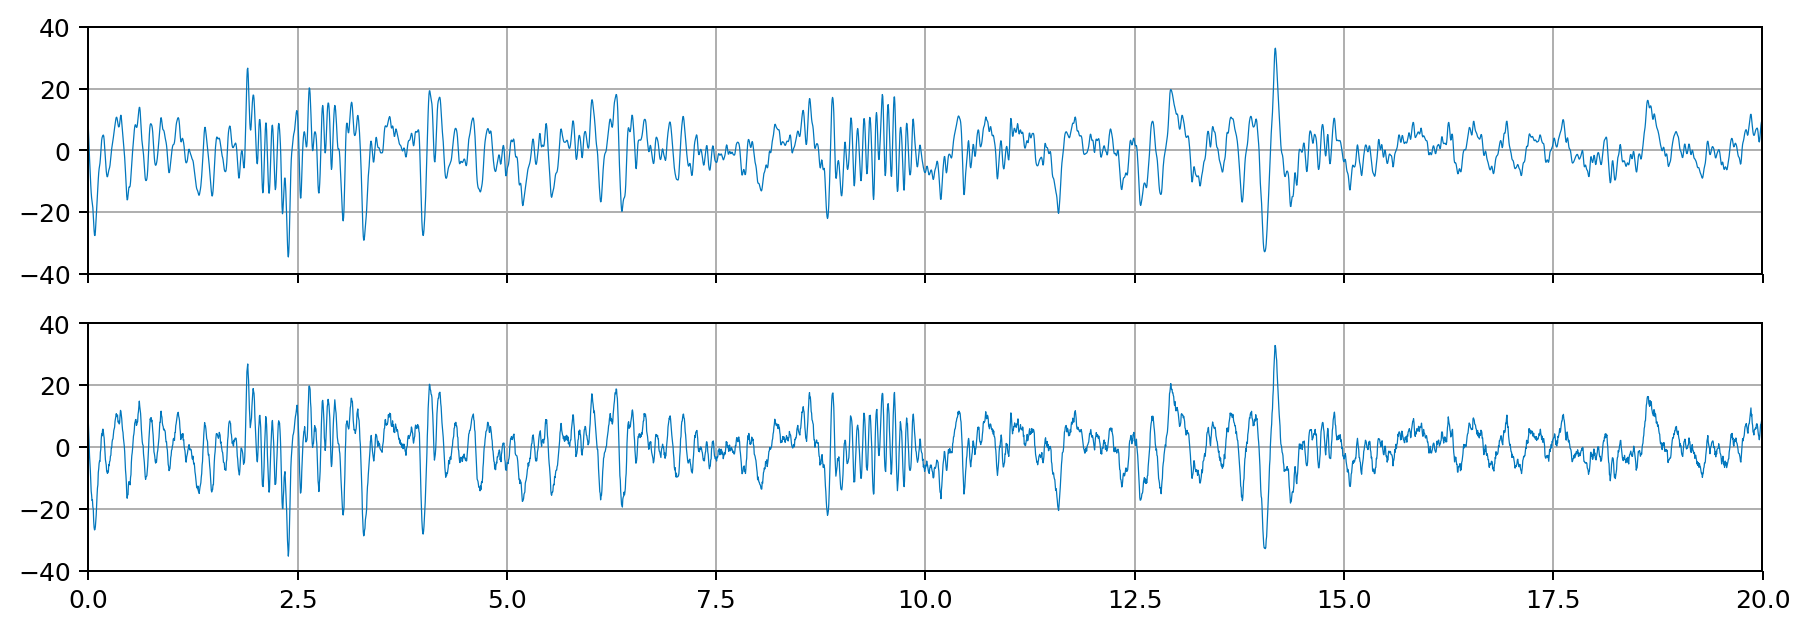

In [38]:
noise_int = 1
original_signal = 0.5*mass_signal[which_mass, :]
noisy_signal  = original_signal + np.random.uniform(low=-noise_int, high=noise_int, size=original_signal.size)

fig, ax = plt.subplots(2, 1, figsize=(12, 4), dpi=180, sharex=True)
time_axis = np.arange(dataset.page_size) / dataset.fs
ax[0].plot(time_axis, original_signal, linewidth=0.5, color=viz.PALETTE['blue'])
ax[1].plot(time_axis, noisy_signal, linewidth=0.5, color=viz.PALETTE['blue'])
for s_ax in ax.flatten():
    s_ax.set_ylim([-40, 40])
    s_ax.set_xlim([time_axis[0], time_axis[-1]])
    # s_ax.set_xlim([time_axis[0], time_axis[-1]/2])
    s_ax.grid()
plt.show()

In [14]:
freq, mean_power_pink = get_mean_spectrum(signal)
freq, mean_power_mass = get_mean_spectrum(mass_signal)

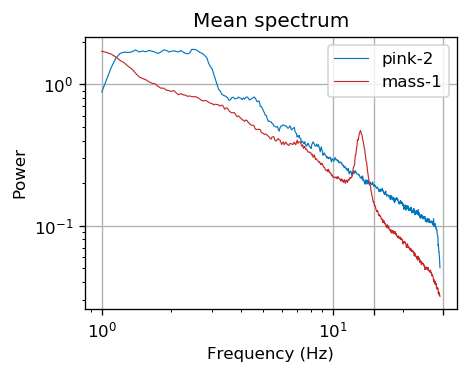

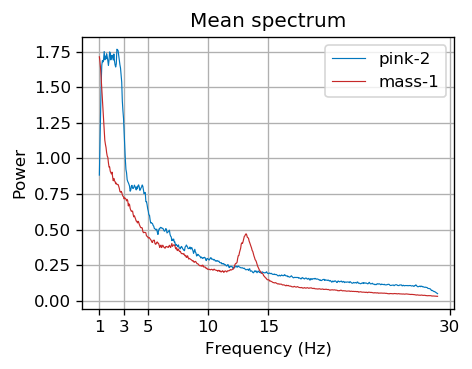

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=120)
ax.set_title("Mean spectrum")
ax.loglog(freq, mean_power_pink, linewidth=0.7, label="pink-%d" % subject_id, color=viz.PALETTE['blue'])
ax.loglog(freq, mean_power_mass, linewidth=0.7, label="mass-%d" % subject_id_mass, color=viz.PALETTE['red'])
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power")
ax.set_xticks([1, 10, 15, 30])
ax.grid()
ax.legend()
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=120)
ax.set_title("Mean spectrum")
ax.plot(freq, mean_power_pink, linewidth=0.7, label="pink-%d" % subject_id, color=viz.PALETTE['blue'])
ax.plot(freq, mean_power_mass, linewidth=0.7, label="mass-%d" % subject_id_mass, color=viz.PALETTE['red'])
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power")
ax.set_xticks([1, 3, 5, 10, 15, 30])
ax.grid()
ax.legend()
plt.show()